# Extractive and Abstractive Text Summarization of South Park Episodes

Student 


## Overview

Text summarization is an exciting yet challenging task in Natural Language Processing (NLP). Developing a model that can digest a large amount of textual data and produce an output that encapsulates the most important information can be a very powerful tool that saves a lot of time and resources. Today, text summarization models are being deployed on legal documents, CNN news articles, medical records, and even whole books. For my capstone project, I wanted to train a text summarization model on South Park dialogue to provide an overview of what happens in the episode. 


## **Business Understanding**

A new start-up would like to create a website that is the source of all things TV, both past and present. Providing information such as air date, character names, episode titles and much more the hope is to become a hub where fanatics can gather all of the information they need about their favorite TV shows. To save some time they would like to investigate using NLP to produce summaries from dialogue that explain the events that take place in a given episode, starting with the popular show South Park. 

Creating a text summarization model trained on South Park dialogue can save the developers of this new website time to focus their efforts on other content of the website. 

## Data
For this project, we utilized the South Park Scripts Dataset from Kaggle. This data set has two files. One contains episode names, air dates, seasons, episode numbers, and descriptions of the episode. While the other includes the episode name, character, and each character's lines. This is a large collection of text with over 300 episodes and 95000 lines. More detailed information on each dataset and its features are listed below:

#### Episodes 
* `Title`- Title of the episode
* `Air Date`- Air date of the episode
* `Code`- Code for the episode, it represents the season and episode
* `#`- Episode number (all time)
* `Description`- General description for episode
* `Season`- Episode's season
* `Episode`- Episode number in the season

#### Lines
* `Title`- Title of the episode
* `Character`- Character
* `Line`- What the character said

For more information on the datasets and the sources behind them please visit the [South Park Scripts Dataset](https://www.kaggle.com/datasets/mustafacicek/south-park-scripts-dataset?select=SouthPark_Lines.csv) on the Kaggle website.

## Data Preprocessing

In [155]:
# Importing necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd 
import re
from wordcloud import WordCloud
from random import randint
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing 
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.model_selection import train_test_split
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [156]:
# Importing South Park episode dataframe and viewing first 5 rows

episodes = pd.read_csv('SouthPark_Episodes.csv')
episodes.head()

,Title,Air Date,Code,#,Description,Season,Episode
0,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.",1,1
1,Weight Gain 4000,"August 20, 1997",102,2,"When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.",1,2
2,Volcano,"August 27, 1997",103,3,"A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano.",1,3
3,Big Gay Al's Big Gay Boat Ride,"September 3, 1997",104,4,"When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park.",1,4
4,An Elephant Makes Love to a Pig,"September 10, 1997",105,5,"Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant.",1,5


In [157]:
# Episodes dataframe information

episodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        309 non-null    object
 1   Air Date     309 non-null    object
 2   Code         309 non-null    int64 
 3   #            309 non-null    int64 
 4   Description  309 non-null    object
 5   Season       309 non-null    int64 
 6   Episode      309 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 17.0+ KB


Our episodes dataframe consists of 309 episodes. The `Title` and `Description` columns in this dataframe will be particularly useful in our analysis. `Title` will be used to merge our two dataframes, while the `Description` of each episode will be **treated as our target variable.**

In [158]:
# Checking for na values in dataframe

episodes.isna().sum()

Title          0
Air Date       0
Code           0
#              0
Description    0
Season         0
Episode        0
dtype: int64

We aren't missing any information in this dataset which is great. Our `Title` and `Description` features are object dtype which is appropriate. All other columns will be dropped from the dataframe. Let's import our lines dataset.

In [159]:
# Importing South Park lines dataframe and viewing first 5 rows

lines = pd.read_csv('SouthPark_Lines.csv')
lines.head()

,Title,Character,Line
0,Cartman Gets an Anal Probe,Scene Description,At the bus stop.
1,Cartman Gets an Anal Probe,The Boys,"School days, school days, teacher's golden ru..."
2,Cartman Gets an Anal Probe,Kyle Broflovski,"Ah, damn it! My little brother's trying to follow me to school again."
3,Cartman Gets an Anal Probe,Ike Broflovski,Eat banana.
4,Cartman Gets an Anal Probe,Kyle,"Ike, you can't come to school with me. [Ike Chortles.]"


In [160]:
# Lines dataframe information

lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95320 entries, 0 to 95319
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      95320 non-null  object
 1   Character  95320 non-null  object
 2   Line       95308 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


Our lines dataframe has 95320 entries in our `Title` and `Character` columns. It appears we are missing 12 entries in our `Line` column. Let's investigate those instances.

In [161]:
# Viewing instances where Line entry is NaN

lines.loc[lines['Line'].isna()] 

,Title,Character,Line
24722,Do the Handicapped Go to Hell?,Cartman,NaN
24724,Do the Handicapped Go to Hell?,Cartman,NaN
27432,A Very Crappy Christmas,"Stan, Kyle",NaN
30605,Osama bin Laden Has Farty Pants,Osama bin Laden,NaN
31625,Here Comes the Neighborhood,Bill Cosby,NaN
45847,Quest for Ratings,Stan,NaN
50080,Trapped in the Closet,R. Kelly,NaN
50391,Free Willzyx,Manuel,NaN
70688,City Sushi,Field reporter,NaN
70823,City Sushi,Field reporter,NaN


Dropping 12 lines from a dataframe that contains >95000 lines seems rather inconsequential, lets drop those instances from the dataframe.

In [162]:
# Dropping NaN values from lines dataframe

lines.dropna(inplace=True)
lines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95308 entries, 0 to 95319
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      95308 non-null  object
 1   Character  95308 non-null  object
 2   Line       95308 non-null  object
dtypes: object(3)
memory usage: 2.9+ MB


Let's do some EDA on our lines dataframe to get a better idea of line distribution in South Park's dialogue.

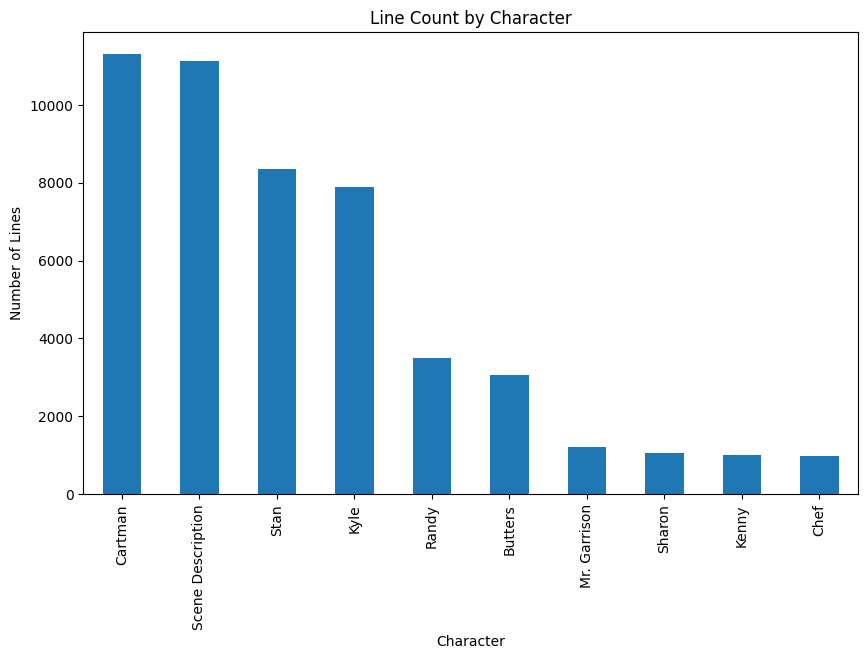

In [163]:
# Plotting top 10 characters based on the number of lines

lines['Character'].value_counts().head(10).plot(kind='bar', 
                                                figsize=(10,6), 
                                                title='Line Count by Character',
                                                xlabel='Character',
                                                ylabel='Number of Lines');

**OBSERVATIONS**

If you are familiar with the show we can see that the usual suspects such as Cartman, Stan, and Kyle have the lion's share of the dialogue in the show. An interesting observation is the Scene Description character has the second most lines, this makes sense as that character is used to describe the setting throughout each episode. For clarity, we may want to consider removing this character from the text entirely.

We now want to concatenate the individual character lines in each episode so that we have an entire script of dialogue associated with a single episode title.


In [164]:
# Concatenate the string
lines['Line'] = lines.groupby(['Title'])['Line'].transform(lambda x : ' '.join(x)) 
lines = lines.drop_duplicates('Title')

# Show the dataframe
lines.head()

,Title,Character,Line
0,Cartman Gets an Anal Probe,Scene Description,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor..."
507,Weight Gain 4000,Scene Description,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ..."
904,Volcano,Scene Description,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji..."
1307,Big Gay Al's Big Gay Boat Ride,Scene Description,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu..."
1832,An Elephant Makes Love to a Pig,Scene Description,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '..."


Perfect! We are now ready to merge our two dataframe using the title of each episode. Before we do that let's make sure we have the same number of episodes in each.

In [165]:
print('Number of episodes in episodes dataframe:', len(episodes.Title))
print('Number of episodes in lines dataframe:', len(lines.Title))

Number of episodes in episodes dataframe: 309
Number of episodes in lines dataframe: 309


We have the same number of episodes in each dataframe which is great. Next, we are going to drop the `Character` column from the lines dataframe. I am doing this for two reasons. First, this text is a dialogue and the characters' names are often spoken to each other, therefore there is little information lost by taking out the text that specifies who is speaking. Second, if we were to add the character names before each sentence it would add more words for our model  to remember, and make sequencing difficult for our model to understand.

In [166]:
# Dropping Character column from lines dataframe

lines = lines.drop('Character', axis=1)
lines.head()

,Title,Line
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor..."
507,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ..."
904,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji..."
1307,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu..."
1832,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '..."


As we mentioned before, the only information we need from our episode dataframe is the `Title` and `Description` features. Let's make a new episode dataframe that consists of only those columns.

In [167]:
# Creating a new episodes dataframe

episodes = episodes[['Title', 'Description']]
episodes

,Title,Description
0,Cartman Gets an Anal Probe,"While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors."
1,Weight Gain 4000,"When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award."
2,Volcano,"A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano."
3,Big Gay Al's Big Gay Boat Ride,"When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park."
4,An Elephant Makes Love to a Pig,"Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant."
...,...,...
304,Turd Burglars,Kyle’s mom looks so good after her fecal transplant that everyone wants to get their hands on her goods. Cartman and the boys jump into the quest for the best microbiome.
305,Basic Cable,Scott Malkinson’s future with the new girl in his class depends on him getting the latest and greatest streaming platform. Scott’s dad works for the local cable company and refuses to move beyond ...
306,Christmas Snow,It's a bleak Christmas Season in South Park this year and it's all Santa's fault. He is single handedly stealing the joy from the holiday. The town just wants their Christmas Spirit back but that ...
307,The Pandemic Special,Randy comes to terms with his role in the COVID-19 outbreak as the on-going pandemic presents continued challenges to the citizens of South Park. The kids happily head back to school but nothing r...


We are now ready to merge the two dataframes on their respective `Title` columns.

In [168]:
# Merging two dataframes into SP_df dataframe

SP_df = pd.merge(lines, episodes, left_on='Title', right_on='Title')
SP_df.head()

,Title,Line,Description
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors."
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award."
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano."
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park."
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant."


In [169]:
# Checking for Nan values in new dataframe

SP_df.isna().sum()

Title          0
Line           0
Description    0
dtype: int64

In [170]:
# Renaming our Line and Description columns
SP_df.rename(columns={'Line': 'Text', "Description": "Summary" }, inplace=True)

# Viewing exxample of dialogue and its associated summary
print("---- Episode Dialogue ----")
print(SP_df.Text[0])
print("---- Summary ----")
print(SP_df.Summary[0])

---- Episode Dialogue ----
At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chortles.] Yeah, go home you little dildo! Dude, don't call my brother a dildo! What's a dildo? Well, I don't know...[He faces Cartman and points at him.] and I'll bet Cartman doesn't know either! I know what it means! Well, what? I'm not telling you. What's a dildo, Kenny? (It's a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that's what Kyle's little brother is all right! [Kyle swings Ike by his feet, knocking Cartman down.] Ow! [Ike Laughs.] Dude, that kicks ass! Yeah, check this one out. Ready Ike? Kick the baby! Don't kick the baby. Kick the baby. He kicks Ike like a football, who lands, knocking down four mailboxes. Cartman yawns. Whoa, Cartman! Looks like you didn't get much sleep last night. That's 'cause I was having these... bogus nightmares

We now have a dataframe that we can use for our text summarization modeling. We will start by using an extractive approach using Gensim.

#### Extractive and Abstractive Summarization

Text summarization can generally be categorized into two classes: **Extractive Summarization** and **Abstractive Summarization**. 

Extractive summarization compiles the most important words, sentences, or phrases from a corpus into a summary. This approach does not necessarily aim to understand the meaning of the text therefore the extracted summary is just a subset of the original text. 

Abstractive summarization models use more advanced NLP techniques to understand semantics and structure and can therefore have new phrases and sentences that are not contained in the original text.

We will take an iterative approach to our model building by first starting with an extractive summarization model using TextRank from Gensim. We can then work our way to more advanced NLP models for abstractive summarization. 

#  Gensim TextRank Model 

Gensim TextRank summarizer is an unsupervised algorithm that summarizes text by extracting the most important sentences from it. It takes two arguments, the first will be a provided text while the second will be a ratio that specifies what fraction of sentences in the original text should be returned as output. 

We would like to match the length of our output as closely as possible to the provided summary (our target variable). Let's find the average ratio of the length of the summary to the length of text in our dataframe.



In [171]:
# Fining the ratio of text to summary

ratios = []
for i in range(len(SP_df)):
    ratios.append(len(SP_df['Summary'][i]) / len(SP_df['Text'][i]))
SP_df['Ratio'] = ratios
SP_df.Ratio.mean()

0.005029402376588137

The length of our summary is 0.5% of the length of our dialogue, which is very small. Let's see how the text rank algorithm performs.

In [172]:
#Importing gensim 3.8.3

!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [173]:
# Importing gensim
import gensim

# Defining textrank function
def textrank(corpus, ratio=None):        
    lst_summaries = [gensim.summarization.summarize(txt,  
                     ratio=ratio) for txt in corpus]    
    return lst_summaries

# Apply the function to corpus
SP_df['predicted'] = textrank(corpus=SP_df.Text, ratio=.005)

In [174]:
# Comparing first 5 summaries

for i in range(5):
  print("-----------------Summary----------------")
  print(SP_df.Summary[i])
  print('-----------------Predicted--------------')
  print(SP_df.predicted[i])
  print('\n')

-----------------Summary----------------
While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.
-----------------Predicted--------------
(It's a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that's what Kyle's little brother is all right!
I can't just sit here, I have to help my stupid brother, or I'll come home without him and my dad will start yelling, "Where's your brother, Kyle?" "You weren't looking out for your little brother, Kyle?" [Whispering.] Okay, okay, let's ditch school and go find him.
All you have to do is fart some more, Cartman, and the Visitors are sure to come!


-----------------Summary----------------
When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.
-----------------Predicted--------------
Children, as you all know, Miss Kathie Lee Gifford will be in South Park to present t

Viewing the summaries above (sorry for the language) you can see that the text rank algorithm did a fairly good job at capturing the information in the dialogue on certain occasions while on others it did not. But for an unsupervised extractive approach to summarization, the information contained in the output is pretty impressive.

### ROUGE Score

For this analysis, we will be using the ROUGE score to measure how well our models produced a viable summary. In particular, we will be using ROUGE-1, ROUGE-2, and ROUGE-L. 

* ROUGE-1 refers to the overlap of unigrams (each word) between the predicted and reference summaries. 
* ROUGE-2 refers to the overlap of bigrams (two words) between the predicted and reference summaries. 
* ROUGE-L takes into account sentence level structure similarity naturally and identifies longest co-occurring in sequence n-grams. 

A ROUGE score close to zero indicates poor similarity between the summary and references. A ROUGE score close to one indicates a strong similarity between the summary and reference. If the summary is identical to one of the reference documents, then the score is 1.

In [175]:
# Installing ROUGE

!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [176]:
# Importing ROUGE

import rouge

score_1 = []
score_2 = []
score_L = []

for i in range(len(SP_df)):   
    rouge_score = rouge.Rouge()    
    scores = rouge_score.get_scores(SP_df.Summary[i], SP_df.predicted[i], avg=True)       
    score_1.append(round(scores['rouge-1']['f'], 2))
    score_2.append(round(scores['rouge-2']['f'], 2))
    score_L.append(round(scores['rouge-l']['f'], 2))    
    
SP_df["Score_1"] = score_1
SP_df['Score_2'] = score_2
SP_df['Score_L'] = score_L
SP_df['Score_avg'] = np.mean(SP_df[['Score_1', 'Score_2', 'Score_L']], axis=1)

The average Rouge-1 score for TextRank is: 0.13
The average Rouge-2 score for TextRank  is: 0.01
The average Rouge-L score for TextRank  is: 0.11
The average of all Rouge scores for TextRank  is: 0.09



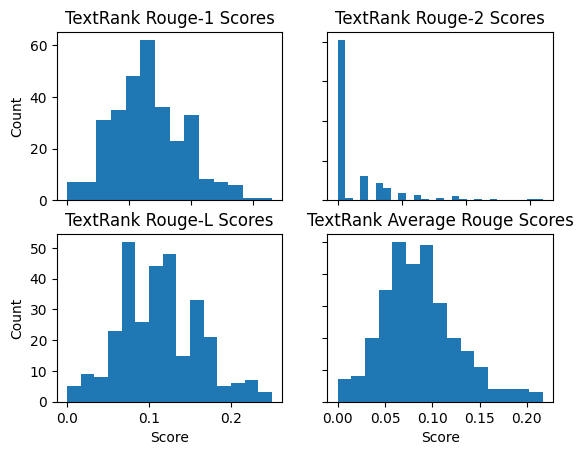

In [177]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(SP_df["Score_1"], bins='auto')
axs[0, 0].set_title('TextRank Rouge-1 Scores')
axs[0, 1].hist(SP_df["Score_2"], bins='auto')
axs[0, 1].set_title('TextRank Rouge-2 Scores')
axs[1, 0].hist(SP_df["Score_L"], bins='auto')
axs[1, 0].set_title('TextRank Rouge-L Scores')
axs[1, 1].hist(SP_df["Score_avg"], bins='auto')
axs[1, 1].set_title('TextRank Average Rouge Scores')

for ax in axs.flat:
    ax.set(xlabel='Score', ylabel='Count')

for ax in axs.flat:
    ax.label_outer()

print('The average Rouge-1 score for TextRank is:', round(SP_df.Score_1.mean(),2))
print('The average Rouge-2 score for TextRank  is:', round(SP_df.Score_2.mean(),2))
print('The average Rouge-L score for TextRank  is:', round(SP_df.Score_L.mean(),2))
print('The average of all Rouge scores for TextRank  is:', round(SP_df.Score_avg.mean(),2))
print()

**OBSERVATIONS**

* An average ROUGE-1 score of **0.13** is not great. However, the higher end of the distribution has ROUGE-1 scores of **0.3** which indicates our extractive summarization method was effective on some texts.

* With an average ROUGE-2 score of **0.01** we can see that our extractive summarization model failed to capture shared bigrams between the predicted and reference summaries.

* With an average ROUGE-L score of **0.11** we see an improvement here over our ROUGE-2 score, however, it still indicates low similarity between summary and reference texts.

* Averaging all of the above ROUGE scores we get a score of **0.09**. This isn't great as ROUGE scores range from 0-1 and scores close to 0 indicate poor similarity between texts. We do see some instances where we achieved an average ROUGE score of > **0.20**, which for a purely extractive unsupervised approach is pretty awesome!

# **Seq2Seq Modeling**

A Sequence to Sequence (Seq2Seq) model involves any problem that deals with sequential information. In regards to natural language processing, this could be useful in translating a text to a different language, providing sentiment analysis, or in our case producing a summary of a text. 

We will provide a Seq2Seq model with an input of sequence with a certain length of words (dialogue), and hopefully produce an output with a different length of words (summary). First, we need to clean the text so that we can then tokenize it.

In [178]:
# Installing contrations
!pip install contractions

# Importing useful libraries to clean text
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import re 
from nltk.stem.wordnet import WordNetLemmatizer
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [179]:
# Creating seq-2-seq dataframe

s2s_df = SP_df[['Title', 'Text', 'Summary']]
s2s_df.head()

,Title,Text,Summary
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors."
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award."
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano."
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park."
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant."


We created a new s2s_df so that we have an easy dataframe to work with that has all of the required information.

In [180]:
# Viewing newly created dataframe inforation
s2s_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    305 non-null    object
 1   Text     305 non-null    object
 2   Summary  305 non-null    object
dtypes: object(3)
memory usage: 17.6+ KB


In [181]:
# Viewing sample of text
print('Length of text:', len(s2s_df['Text'][0]))
s2s_df['Text'][0]

Length of text: 23816


'At the bus stop. School days, school days, teacher\'s golden ru... Ah, damn it! My little brother\'s trying to follow me to school again. Eat banana. Ike, you can\'t come to school with me. [Ike Chortles.] Yeah, go home you little dildo! Dude, don\'t call my brother a dildo! What\'s a dildo? Well, I don\'t know...[He faces Cartman and points at him.] and I\'ll bet Cartman doesn\'t know either! I know what it means! Well, what? I\'m not telling you. What\'s a dildo, Kenny? (It\'s a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that\'s what Kyle\'s little brother is all right! [Kyle swings Ike by his feet, knocking Cartman down.] Ow! [Ike Laughs.] Dude, that kicks ass! Yeah, check this one out. Ready Ike? Kick the baby! Don\'t kick the baby. Kick the baby. He kicks Ike like a football, who lands, knocking down four mailboxes. Cartman yawns. Whoa, Cartman! Looks like you didn\'t get much sleep last night. That\'s \'cause I was having these... bogus nightmares. Really?

Before we clean our text we need to address the dimensionality of our data. In our text example above you can see that the length of the text is approx 24,000 words. That is a lot of information for our model to remember once we have sequenced and embedded our text on 305 documents. 

To make the length of our text more manageable we will again use the text rank function, this time at a ratio of 20%. This will ideally provide us with text that is <5000 words while still containing the most important information.

In [182]:
# Applying textrank function on s2s_df

import gensim
def textrank(corpus, ratio=None):        
    lst_summaries = [gensim.summarization.summarize(txt,  
                     ratio=ratio) for txt in corpus]    
    return lst_summaries

# Apply the function to corpus
s2s_df['reduced_text'] = textrank(corpus=s2s_df.Text, ratio=.20)

In [183]:
# Viewing sample of text

print('Length of text:', len(s2s_df['reduced_text'][0]))
s2s_df['reduced_text'][0]

Length of text: 7490


'My little brother\'s trying to follow me to school again.\nIke, you can\'t come to school with me.\n[Ike Chortles.] Yeah, go home you little dildo!\nDude, don\'t call my brother a dildo!\n(It\'s a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that\'s what Kyle\'s little brother is all right!\n[Kyle swings Ike by his feet, knocking Cartman down.] Ow!\n[Ike Laughs.] Dude, that kicks ass!\nHe kicks Ike like a football, who lands, knocking down four mailboxes.\nLooks like you didn\'t get much sleep last night.\n[A Visitor peeks inside.] ...and then the next thing I remember, I was being drug through a hallway.\nCartman is laying face down, Visitors lower his pajamas.\nThat wasn\'t a dream Cartman, those were Visitors!\nYeah, they abduct people and they mutilate cows.\nSay, did any of you children see the alien space ship last night?\nYeah, fat boy saw it!\nThey gave you an anal probe Cartman?\nYou children watch that fat boy now.\nChef walks back to his car, there is a

That is much more manageable, now it's time to clean our text. Let's define a function that can provide us with clean text.

As you can see in the sample text above there is a lot of punctuation, capitalization, contractions, etc. that will interfere with our ability to provide adequate sequences to our model. Some examples of how you can clean your text are :

1.   Removing common words that hold no real information, these are known as stopwords (i.e “the”, “is” and “and”).
2.   Removing punctuation and special characters.
3. Make every word lowercase so that our model doesn't recognize "Vitamin" and "vitamin" as two different words.
4.   Fixing contrations (we'll = we will).
5.   Lemmatization, convert the word to its root word.

In [184]:
# Installing contrations
!pip install contractions

# Creating stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

## cleaning function
def clean_text(txt):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt)
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower()
    ### fix contractions
    txt = contractions.fix(txt)    
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### lemmatization (convert the word into root word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    lst_txt = [word for word in lst_txt if word not in 
                   stopwords_list]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [185]:
# Cleaning our reduced text in s2s_df
cleaned_text = []
for t in s2s_df['reduced_text']:
    cleaned_text.append(clean_text(t))

# Viewing sample
cleaned_text[0]

'little brother trying follow school ike cannot come school ike chortle yeah go home little dildo dude call brother dildo plastic dick go vagina others laugh heyeah kyles little brother right kyle swing ike foot knocking cartman ow ike laugh dude kick kick ike like football land knocking four mailbox look like get much sleep last night visitor peek inside next thing remember wa drug hallway cartman laying face visitor lower pajama wa dream cartman visitor yeah abduct people mutilate cow say child see alien space ship last night yeah fat boy saw gave anal probe cartman child watch fat boy chef walk back car picture visitor shirt word believe written cartman go catatonic chef drive kick ike fly first window school bus crash window side bus pull away leaving ike behind bus stop kyle kneeling seat looking back window kyle run front bus stop buuuuus cartman visitor saw make hard right flinging kid onto left side bus cow turn inside time cow start running away child friend mr hat going tell 

As you can see the text above looks less busy, grammatically it doesn't make sense but the format it is in now will be much easier for our model to understand. 

Let's apply the same cleaning function to the summary column of our dataframe.

In [186]:
# Cleaning our summaries in s2s_df

cleaned_summary = []
for t in s2s_df['Summary']:
    cleaned_summary.append(clean_text(t))

# Viewing sample
cleaned_summary[0]

'boy waiting school bus cartman explains odd nightmare previous night involving alien visitor'

In [187]:
# Creating new columns in dataframe for cleaned texts

s2s_df['cleaned_text']=cleaned_text
s2s_df['cleaned_summary']=cleaned_summary
s2s_df.head()

,Title,Text,Summary,reduced_text,cleaned_text,cleaned_summary
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.","My little brother's trying to follow me to school again.\nIke, you can't come to school with me.\n[Ike Chortles.] Yeah, go home you little dildo!\nDude, don't call my brother a dildo!\n(It's a pla...",little brother trying follow school ike cannot come school ike chortle yeah go home little dildo dude call brother dildo plastic dick go vagina others laugh heyeah kyles little brother right kyle ...,boy waiting school bus cartman explains odd nightmare previous night involving alien visitor
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.","Hey Stan, did you see that rainbow this morning?\nWell, you know, you'll just be sitting there, minding your own business, and they'll come, marching in and crawl up your leg and start biting the ...",hey stan see rainbow morning well know sitting minding business come marching crawl leg start biting inside like ehy get stupid rainbow silence cartman hell talking silence one south park student ...,cartmans environmental essay win national contest america sweetheart kathie lee gifford come south park present award
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano.","Jimbo, Ned, and the boys are waiting for Cartman.\nOkay, Mom. Ready to go hunting, Cartman?\nYeah, my Uncle Jimbo says we gotta get up there early.\nRight, Uncle Jimbo?\nDon't worry Mrs. Cartman, ...",jimbo ned boy waiting cartman okay mom ready go hunting cartman yeah uncle jimbo say got get early right uncle jimbo worry mr cartman well take good care know get scary wood remember mommy far awa...,weekend trip experience finer point camping fishing blowing animal smithereens threatened erupting volcano
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park.","A dog walks up to the boys.\nThat's my new dog Sparky.\nGood boy, Sparky.\nEverybody knows that Sylvester is the toughest dog in South Park.\nSparky'll kick his ass.\nSylvester starts after Sparky...",dog walk boy new dog sparky good boy sparky everybody know sylvester toughest dog south park sparkyll kick sylvester start sparky yeah dude think dog gay dog gay homosexual stan look back study si...,stan discovers new dog sparky gay becomes confused loses play big homecoming football game north park
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant.","Hey Stan, where'd you get that black eye?

In [188]:
s2s_df.replace('', np.nan, inplace=True)
s2s_df.dropna(axis=0,inplace=True)

Our next step is to investigate how many words we have in our dialogue after we have ranked and cleaned our texts. This will help us to determine an appropriate sequence length and find rare words in our corpus. We want to limit the number of words our model needs to remember therefore rare words should be ignored.

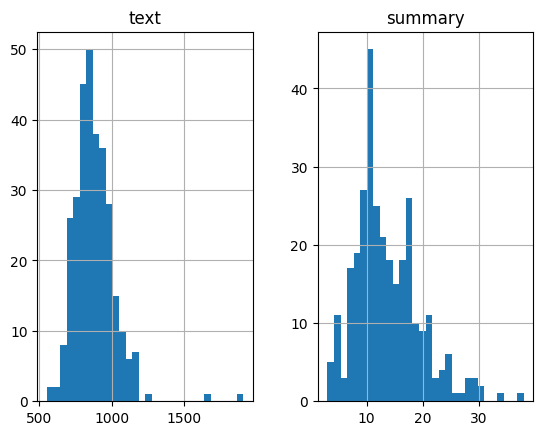

In [189]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in s2s_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in s2s_df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [190]:
cnt=0
for i in s2s_df['cleaned_summary']:
    if(len(i.split())<=25):
        cnt=cnt+1
print(cnt/len(s2s_df['cleaned_summary']))

0.9606557377049181


In [191]:
cnt=0
for i in s2s_df['cleaned_text']:
    if(len(i.split())<=1000):
        cnt=cnt+1
print(cnt/len(s2s_df['cleaned_text']))

0.8590163934426229


By setting our maximum text length to 1000 words, we can still keep 85% of our corpus while making our modeling process less computationally expensive. 

The sequence length of all texts needs to be the same. We accomplish this by padding any text that has fewer words than our maximum text length using a numeric value (0) which brings all sequences up to the same length.

Let's define the maximum lengths now.

In [192]:
#Defining maximum sequence lengths
max_text_len=1000
max_summary_len=25

Now that we have defined our maximum length variables, lets remove the instances where our text length is greater than our max summary or max text limits.

In [193]:
# Removing texts that are greater length than our max_text_ln/max_summary_len variables

cleaned_text =np.array(s2s_df['cleaned_text'])
cleaned_summary=np.array(s2s_df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

print("Number of episodes in corpus:", len(df))

251

It's time to take a look at word frequencies in both dialogue and summary texts. This gives us an idea of what words are most common, and more importantly what words are so infrequent we can exclude them from our tokenization and sequencing processes. We will build frequency distributions as well as fun visuals called Wordclouds to illustrate the most common words.

In [250]:
# Defining plot_wordcloud function

def plot_wordcloud(text, color_func):
    wc = WordCloud(width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(10, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

In [196]:
# Defining frequency distribution function

def plot_freq_dist(df):

  lst_tokens = nltk.tokenize.word_tokenize(df.str.cat(sep=" "))
  ngrams = [1]
    
  dtf_freq = pd.DataFrame()
  for n in ngrams:
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
    dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                          ["word","freq"])
    dtf_n["ngrams"] = n
    dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq_X= dtf_freq.sort_values(["ngrams","freq"], ascending=
                         [True,False])
    
  sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
  data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
  plt.show()

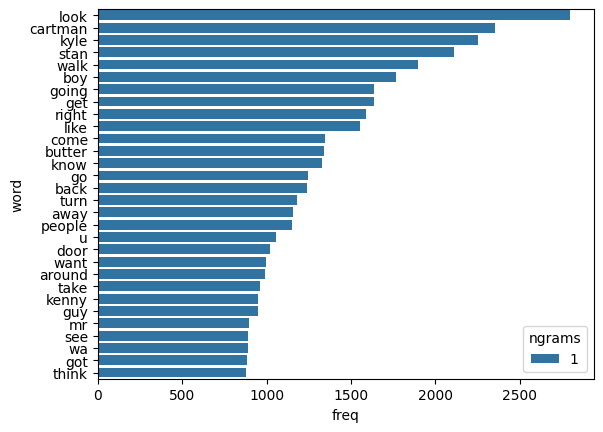

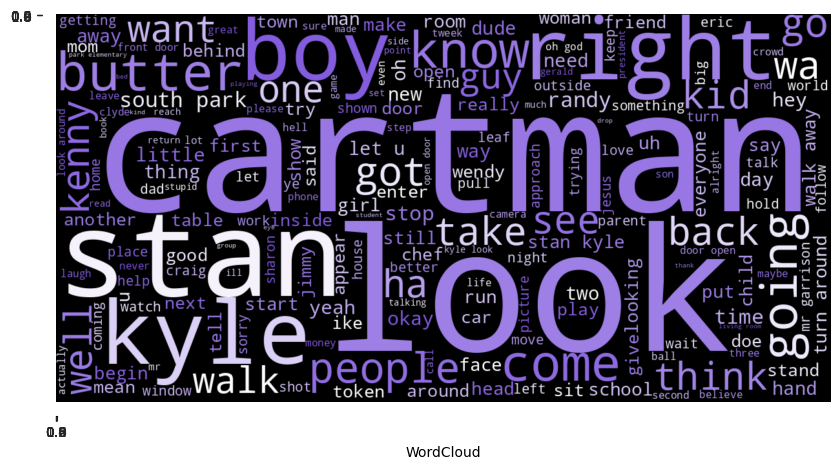

In [251]:
# Plotting word frequency and wordcloud for text corpus

plot_freq_dist(df['text'])
plot_wordcloud(''.join(df['text'].values.tolist()), wc_blue_color_func)

OBSERVATIONS

Looking at the frequency distribution and wordcloud above we can see that characters such as **Cartman**, **Stan**, and **Kyle** dominate the text. Considering the text mainly consists of a dialogue between those characters this makes a lot of sense. Frequent words such as **going**, **boy**, **walk** and **kid** could be attributed to the scene description "character" in the text.

Let's do the same analysis on the summary text.

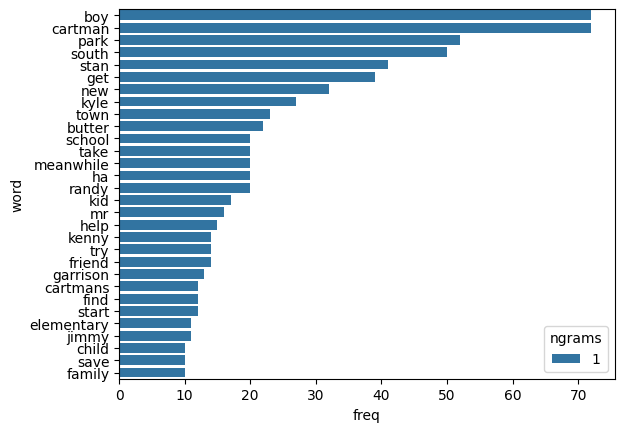

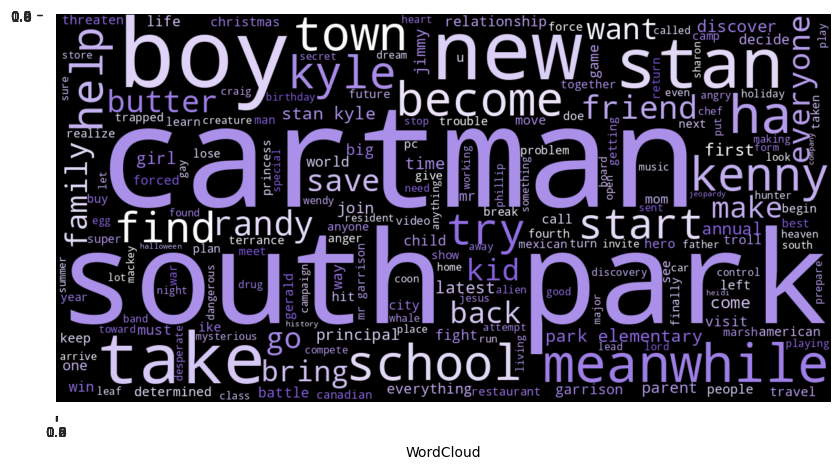

In [198]:
# Plotting word frequency distribution and wordcloud for summary text 

plot_freq_dist(df['summary'])
plot_wordcloud(''.join(df['summary'].values.tolist()),wc_blue_color_func)

OBSERVATIONS

While there are certainly similarities between the text and the summary corpus and their respective word frequencies (characters are again very prevalent), we see more narrative vocabulary in the summary text. Words such as **south**, **park**, **meanwhile**, and **elementary** are examples of this narrative vocabulary.

Now that we have found the appropriate sequence lengths and performed some visual EDA. The next step is to add special tokens to the summary texts. These special tokens will provide context for our decoder model for when to start and end the prediction of the target sequence.

In [199]:
# Adding special tokens to the beginning and end of summary texts

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [259]:
# Splitting data into training and validation sets

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

Here we want to see how prevalent rare words are in our vocabulary. To limit the number of words our model has to remember, words that don't often appear in the corpus are considered to be rare and should not be included in our tokenization process. For our dialouge texts, we will consider a word to be rare if appears less than 3 times in the corpus.

In [264]:
# Fitting tokenizer on text training data

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# Rare words threshold

thresh=3
count=0
total_count=0

for key,value in x_tokenizer.word_counts.items():
    total_count=total_count+1
    if(value<thresh):
        count=count+1

x_vocab = total_count - count

Number of words in text corpus: 5560


We are now going to use Keras Tokenizer and its fit_on_texts and texts_to_sequences methods. 

The fit_on_texts method creates a word_index based on word frequency, lower integer values mean a more frequent word. The texts_to_sequences method takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. 

After tokenizing padding sequencing and paddWe will then be able to start the modeling process.

In [265]:
#Fitting tokenizer on text training data

x_tokenizer = Tokenizer(x_vocab) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences for train and validation sets
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding upto maximum length
x_tr    =   kprocessing.sequence.pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   kprocessing.sequence.pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary +1 for padding token
x_voc   =  x_tokenizer.num_words + 1

print('Number of words in Text vocabulary:', x_voc)

Number of words in Text vocabulary: 5561


Lets apply the same process to our Summary texts.

Looking at our frequency distribution plot from earlier we see that the vocabulary in our summary texts is limited and we rapidly approach lower word frequencies in our top 30 words. Because of this we will set a lower threshold for what is considered a rare word, lets's establish this threshold as 2 for our summary texts.

In [266]:
# Fitting tokenizer on summary training data

y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_tr))

# Rare words threshold

thresh=2
count=0
total_count=0

for key,value in y_tokenizer.word_counts.items():
    total_count=total_count+1
    if(value<thresh):
        count=count+1

y_vocab = total_count - count

In [267]:
# Fitting tokenizer on summary training data 

y_tokenizer = Tokenizer(y_vocab) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences for train and validation sets
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding upto maximum length
y_tr    =   kprocessing.sequence.pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   kprocessing.sequence.pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

print('Number of words in Summary vocabulary:', y_voc)

Number of words in Summary vocabulary: 457


## Model 1

In our modeling process, we will use an Encoder/Decoder architecture with Long Short Term Memory (LSTM) components. The Endoder will read the entire input sequence and produce hidden states that will then be used as inputs to the Decoder.

Our first model will include the following:

* An Embedding layer, which turns our positive word index values into dense vectors of defined size. 

* Three stacked unidirectional LSTM layers, that will return a sequence as well as the cell state and hidden state in the final layer.

* The final Time Distributed Dense layer

In [207]:
from keras import backend as K 
K.clear_session()

latent_dim = 250
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 100)    556100      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 1000, 250),  351000      ['embedding[0][0]']              
                                 (None, 250),                                                     
                                 (None, 250)]                                                     
                                                                                              

In [208]:
# Compile model with rmsprop optimizer
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


Training a neural network can take a lot of time so we want to be sure to establish a callback to monitor validation loss. When the model recognizes that the validation isn't decreasing through 2 epochs it will stop the training before the maximum number of epochs has been reached, in this case, 50 epochs.

In [209]:
training_1=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],
                               y_tr.shape[1], 1)[:,1:],
                               epochs=50,
                               callbacks= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
                               batch_size=128, 
                               validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/50
2/2 [==============================] - 29s 9s/step - loss: 6.1048 - val_loss: 5.9564
Epoch 2/50
2/2 [==============================] - 15s 7s/step - loss: 5.8974 - val_loss: 3.9297
Epoch 3/50
2/2 [==============================] - 15s 7s/step - loss: 3.6521 - val_loss: 2.0442
Epoch 4/50
2/2 [==============================] - 14s 7s/step - loss: 2.6704 - val_loss: 2.1370
Epoch 5/50
2/2 [==============================] - 14s 7s/step - loss: 2.6081 - val_loss: 1.9258
Epoch 6/50
2/2 [==============================] - 14s 7s/step - loss: 2.4824 - val_loss: 1.8509
Epoch 7/50
2/2 [==============================] - 14s 7s/step - loss: 2.4278 - val_loss: 1.8120
Epoch 8/50
2/2 [==============================] - 14s 7s/step - loss: 2.4196 - val_loss: 1.9814
Epoch 9/50
2/2 [==============================] - 14s 7s/step - loss: 2.5734 - val_loss: 1.8905
Epoch 9: early stopping


In [210]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [211]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [212]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [213]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [214]:
pred_df = pd.DataFrame(columns=['Text', 'Original_Summary', 'Predicted_Summary'])
text = []
summary = []
pred_summary = []
for i in range(len(x_val)):
  text.append(seq2text(x_val[i]))
  summary.append(seq2summary(y_val[i]))
  pred_summary.append(decode_sequence(x_val[i].reshape(1,max_text_len)))

1/1 [==============================] - 0s 26ms/step


In [215]:
# Creating pred_df to store predicted and reference texts

pred_df.Text = text
pred_df.Original_Summary = summary
pred_df.Predicted_Summary = pred_summary
pred_df[['Original_Summary', 'Predicted_Summary']].head(10)

,Original_Summary,Predicted_Summary
0,boy school one boy discover stans mom ha found new trouble,boy boy boy boy
1,cartman determined find kyle butter trapped evil creature break,boy boy boy boy
2,south park,boy boy boy boy
3,new one time next stop south park south park randy boy,boy boy boy boy
4,stan join war fight world,boy boy boy boy
5,stans life home school randys everything even force sharon new,boy boy boy boy
6,boy jimmy visit,boy boy boy boy
7,cartman power us become,boy boy boy boy
8,boy town become,boy boy boy boy
9,randy determined stan win year come plan stan first place,boy boy boy boy


Our predicted summary does not make much sense. Our model did however capture some prominent vocabulary in the summary corpus as **boy** was the most frequently observed word in our summary corpus.

Let's see how our ROUGE scores are compared to the extractive summarization approach from earlier.

In [268]:
# Calculating Rouge scores and storing in pred_df
score_1 = []
score_2 = []
score_L = []

for i in range(len(pred_df)):   
    rouge_score = rouge.Rouge()    
    scores = rouge_score.get_scores(pred_df.Original_Summary[i], pred_df.Predicted_Summary[i], avg=True)       
    score_1.append(round(scores['rouge-1']['f'], 2))
    score_2.append(round(scores['rouge-2']['f'], 2))
    score_L.append(round(scores['rouge-l']['f'], 2))    
    
pred_df["Score_1"] = score_1
pred_df['Score_2'] = score_2
pred_df['Score_L'] = score_L
pred_df['Score_avg'] = np.mean(pred_df[['Score_1', 'Score_2', 'Score_L']], axis=1)

The average Rouge-1 score for Model 1 is: 0.09
The average Rouge-2 score for Model 1 is: 0.0
The average Rouge-L score for Model 1 is: 0.09
The average of all Rouge scores for Model 1 is: 0.06



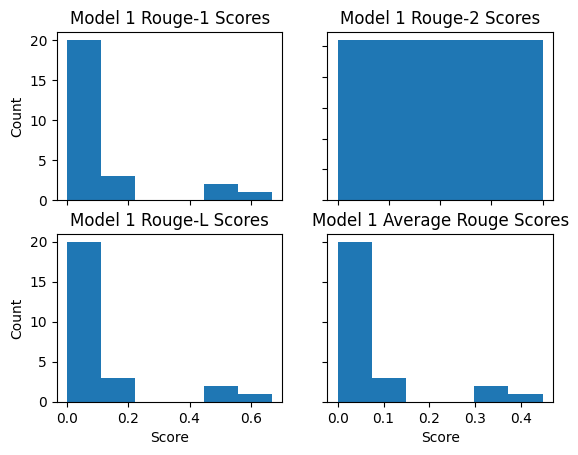

In [269]:
# Plotting Rouge scores for Model 1

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(pred_df["Score_1"], bins=20)
axs[0, 0].set_title('Model 1 Rouge-1 Scores')
axs[0, 1].hist(pred_df["Score_2"], bins=20)
axs[0, 1].set_title('Model 1 Rouge-2 Scores')
axs[1, 0].hist(pred_df["Score_L"], bins=20)
axs[1, 0].set_title('Model 1 Rouge-L Scores')
axs[1, 1].hist(pred_df["Score_avg"], bins=20)
axs[1, 1].set_title('Model 1 Average Rouge Scores')

for ax in axs.flat:
    ax.set(xlabel='Score', ylabel='Count')

for ax in axs.flat:
    ax.label_outer()

print('The average Rouge-1 score for Model 1 is:', round(pred_df.Score_1.mean(),2))
print('The average Rouge-2 score for Model 1 is:', round(pred_df.Score_2.mean(),2))
print('The average Rouge-L score for Model 1 is:', round(pred_df.Score_L.mean(),2))
print('The average of all Rouge scores for Model 1 is:', round(pred_df.Score_avg.mean(),2))
print()

**OBSERVATIONS**

Our first model scored very poorly. Because the most common word in our summary vocabulary is **boy** and we have reduced the number of possible words that our model can use as output in its target sequence, it is likely that by repeatedly producing the word **boy** our model yields inflated ROUGE scores. This suggests our ROUGE scores are lower than they seem and our Gensim text rank algorithm has performed better.

Let's see if we can improve our output in our next model.

### **Model 2**
For our next model, we will incorporate embeddings from Stanford University's *Global Vectors for Word Representation* or *GloVe*. These are pre-trained embeddings performed on aggregated global word-word co-occurrence statistics from a corpus. For further information on GloVe and its methodologies please visit their [website](https://nlp.stanford.edu/projects/glove/).


Our second model will include the following:

* An Embedding layer with pre-trained weights from Stanfords *GloVe*

* Three stacked unidirectional LSTM layers, that will return a sequence as well as the cell state and hidden state in the final layer.

* The final Time Distributed Dense layer

In [218]:
# Downloading glove file

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-04-12 00:11:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-12 00:11:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-12 00:11:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [219]:
# New train_test_split to use for glove embeddings

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [220]:
# Creating new dictionary with glove embeddings

embeddings_dictionary = dict()
glove_file = open("glove.6B.100d.txt", encoding="utf8")
for line in glove_file:  
    records = line.split()  
    word = records[0]  
    vector_dimensions = np.asarray(records[1:], dtype='float32')               
    embeddings_dictionary [word] = vector_dimensions   

glove_file.close()

In [221]:
#prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

X_dic_vocabulary = x_tokenizer.word_index

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   kprocessing.sequence.pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   kprocessing.sequence.pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

## start the matrix (length of vocabulary x vector size) with all 0s
X_embeddings = np.zeros((len(X_dic_vocabulary)+1, 100)) 

for word,idx in X_dic_vocabulary.items():
    ## update the row with vector
    try:
        X_embeddings[idx] =  embeddings_dictionary[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [222]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_dic_vocabulary = y_tokenizer.word_index

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   kprocessing.sequence.pad_sequences(y_tr_seq,  maxlen=max_summary_len, padding='post')
y_val   =   kprocessing.sequence.pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
y_voc   =  y_tokenizer.num_words + 1

 ## start the matrix (length of vocabulary x vector size) with all 0s
y_embeddings = np.zeros((len(y_dic_vocabulary)+1, 100)) 

for word,idx in y_dic_vocabulary.items():
    ## update the row with vector
    try:
        y_embeddings[idx] =  embeddings_dictionary[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [223]:
X_embeddings.shape

(13459, 100)

In [224]:
from keras import backend as K 
K.clear_session()

latent_dim = 250
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_embeddings.shape[0], X_embeddings.shape[1], weights=[X_embeddings], trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_embeddings.shape[0], y_embeddings.shape[1], weights=[y_embeddings], trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 100)    1345900     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 1000, 250),  351000      ['embedding[0][0]']              
                                 (None, 250),                                                     
                                 (None, 250)]                                                     
                                                                                              

In [225]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [226]:
training_2=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],
                               y_tr.shape[1], 1)[:,1:],
                               epochs=50,
                               callbacks= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
                               batch_size=128, 
                               validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/50
2/2 [==============================] - 27s 8s/step - loss: 6.0443 - val_loss: 5.4628
Epoch 2/50
2/2 [==============================] - 14s 7s/step - loss: 4.7247 - val_loss: 2.1329
Epoch 3/50
2/2 [==============================] - 15s 7s/step - loss: 2.6450 - val_loss: 1.9586
Epoch 4/50
2/2 [==============================] - 14s 7s/step - loss: 2.5223 - val_loss: 1.7901
Epoch 5/50
2/2 [==============================] - 14s 7s/step - loss: 2.4679 - val_loss: 1.7566
Epoch 6/50
2/2 [==============================] - 14s 7s/step - loss: 2.5424 - val_loss: 1.7475
Epoch 7/50
2/2 [==============================] - 14s 7s/step - loss: 2.3802 - val_loss: 1.6816
Epoch 8/50
2/2 [==============================] - 14s 7s/step - loss: 2.3271 - val_loss: 1.6296
Epoch 9/50
2/2 [==============================] - 14s 7s/step - loss: 2.3007 - val_loss: 1.5965
Epoch 10/50
2/2 [==============================] - 14s 7s/step - loss: 2.3548 - val_loss: 1.6127
Epoch 11/50
2/2 [======================

In [227]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [228]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [229]:
pred_df2 = pd.DataFrame(columns=['Text', 'Original_Summary', 'Predicted_Summary'])
text2 = []
summary2 = []
pred_summary2 = []
for i in range(len(x_val)):
  text2.append(seq2text(x_val[i]))
  summary2.append(seq2summary(y_val[i]))
  pred_summary2.append(decode_sequence(x_val[i].reshape(1,max_text_len)))

1/1 [==============================] - 0s 25ms/step


In [230]:
pred_df2.Text = text
pred_df2.Original_Summary = summary
pred_df2.Predicted_Summary = pred_summary
pred_df2[['Original_Summary', 'Predicted_Summary']].head(10)

,Original_Summary,Predicted_Summary
0,boy school one boy discover stans mom ha found new trouble,boy boy boy boy
1,cartman determined find kyle butter trapped evil creature break,boy boy boy boy
2,south park,boy boy boy boy
3,new one time next stop south park south park randy boy,boy boy boy boy
4,stan join war fight world,boy boy boy boy
5,stans life home school randys everything even force sharon new,boy boy boy boy
6,boy jimmy visit,boy boy boy boy
7,cartman power us become,boy boy boy boy
8,boy town become,boy boy boy boy
9,randy determined stan win year come plan stan first place,boy boy boy boy


In [231]:
pred_df2.Text = text2
pred_df2.Original_Summary = summary2
pred_df2.Predicted_Summary = pred_summary2
pred_df2.head()

score_1 = []
score_2 = []
score_L = []

for i in range(len(pred_df2)):   
    rouge_score = rouge.Rouge()    
    scores = rouge_score.get_scores(pred_df2.Original_Summary[i], pred_df2.Predicted_Summary[i], avg=True)       
    score_1.append(round(scores['rouge-1']['f'], 2))
    score_2.append(round(scores['rouge-2']['f'], 2))
    score_L.append(round(scores['rouge-l']['f'], 2))    
    
pred_df2["Score_1"] = score_1
pred_df2['Score_2'] = score_2
pred_df2['Score_L'] = score_L
pred_df2['Score_avg'] = np.mean(pred_df2[['Score_1', 'Score_2', 'Score_L']], axis=1)

The average Rouge-1 score for Model 2 is: 0.17
The average Rouge-2 score for Model 2 is: 0.0
The average Rouge-L score for Model 2 is: 0.17
The average of all Rouge scores for Model 2 is: 0.11



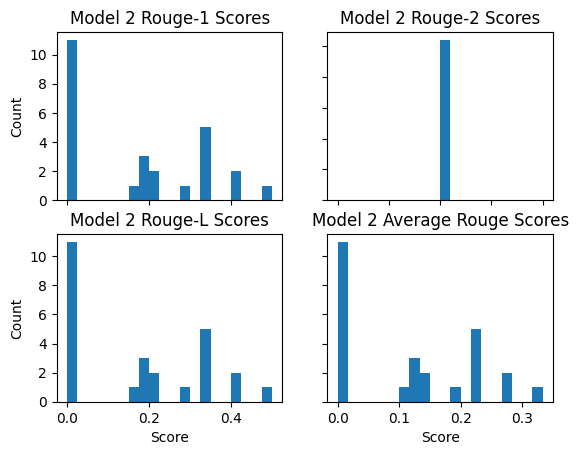

In [232]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(pred_df2["Score_1"], bins=20)
axs[0, 0].set_title('Model 2 Rouge-1 Scores')
axs[0, 1].hist(pred_df2["Score_2"], bins=20)
axs[0, 1].set_title('Model 2 Rouge-2 Scores')
axs[1, 0].hist(pred_df2["Score_L"], bins=20)
axs[1, 0].set_title('Model 2 Rouge-L Scores')
axs[1, 1].hist(pred_df2["Score_avg"], bins=20)
axs[1, 1].set_title('Model 2 Average Rouge Scores')

for ax in axs.flat:
    ax.set(xlabel='Score', ylabel='Count')

for ax in axs.flat:
    ax.label_outer()

print('The average Rouge-1 score for Model 2 is:', round(pred_df2.Score_1.mean(),2))
print('The average Rouge-2 score for Model 2 is:', round(pred_df2.Score_2.mean(),2))
print('The average Rouge-L score for Model 2 is:', round(pred_df2.Score_L.mean(),2))
print('The average of all Rouge scores for Model 2 is:', round(pred_df2.Score_avg.mean(),2))
print()

**OBSERVATIONS**

Our first model scored very poorly. Because the most common word in our summary vocabulary is **boy**, and we have reduced the number of possible words our model can output in our target sequence, it is likely that by repeatedly prodcuing the word **boy** our model yields inflated ROUGE scores. So far our Gensim text rank has performed better.

Let's see if we can improve our output in our next model.

## Model 3

For third model we will experiment with bidirectional LSTM components, these allow the input sequence to flow backward from in an additional LSTM layer. This gives the model better context of the input sequence information. We then combine the outputs from both LSTM layers with concatenation.

Our third model will include the following:

* An Embedding layer with pre-trained weights from Stanfords *GloVe*

* Three stacked Bidirectional LSTM layers

* The final Time Distributed Dense layer


In [233]:
lstm_units=250
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_embeddings.shape[0], X_embeddings.shape[1], weights=[X_embeddings], trainable=True)(encoder_inputs)

### bi-lstm 1
layer_x_bilstm = Bidirectional(LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_1")
x_out, _, _, _, _ = layer_x_bilstm(enc_emb)
### bi-lstm 2
layer_x_bilstm = Bidirectional(LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_2")
x_out, _, _, _, _ = layer_x_bilstm(x_out)
### bi-lstm 3 (here final states are collected)
layer_x_bilstm = Bidirectional(LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_3")
x_out, forward_h, forward_c, backward_h, backward_c = layer_x_bilstm(x_out)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

### embedding
decoder_inputs = Input(shape=(None,))

layer_y_emb = Embedding(y_embeddings.shape[0], y_embeddings.shape[1], 
               weights=[y_embeddings], trainable=False)

y_emb = layer_y_emb(decoder_inputs)

### lstm
layer_y_lstm = LSTM(name="y_lstm", units=lstm_units*2, dropout=0.2, return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(y_out)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1000, 100)    1345900     ['input_6[0][0]']                
                                                                                                  
 x_lstm_1 (Bidirectional)       [(None, 1000, 500),  702000      ['embedding_2[0][0]']            
                                 (None, 250),                                                     
                                 (None, 250),                                                     
                                 (None, 250),                                               

In [234]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [235]:
training_3=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],
                               y_tr.shape[1], 1)[:,1:],
                               epochs=50,
                               callbacks= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
                               batch_size=128, 
                               validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/50
2/2 [==============================] - 36s 12s/step - loss: 5.9711 - val_loss: 3.2852
Epoch 2/50
2/2 [==============================] - 20s 10s/step - loss: 3.4202 - val_loss: 2.0219
Epoch 3/50
2/2 [==============================] - 21s 10s/step - loss: 2.5998 - val_loss: 2.0170
Epoch 4/50
2/2 [==============================] - 20s 10s/step - loss: 2.5257 - val_loss: 1.9480
Epoch 5/50
2/2 [==============================] - 20s 10s/step - loss: 2.4875 - val_loss: 1.9115
Epoch 6/50
2/2 [==============================] - 20s 10s/step - loss: 2.3966 - val_loss: 1.7603
Epoch 7/50
2/2 [==============================] - 20s 10s/step - loss: 2.3227 - val_loss: 1.6852
Epoch 8/50
2/2 [==============================] - 20s 10s/step - loss: 2.3082 - val_loss: 1.9317
Epoch 9/50
2/2 [==============================] - 20s 10s/step - loss: 2.5364 - val_loss: 1.8199
Epoch 9: early stopping


In [236]:
# Prediction Encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
encoder_model.summary()

## double the lstm units if you used bidirectional lstm
lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
## states of the previous time step
encoder_out = Input(shape=(x_tr.shape[1], lstm_units))
state_h, state_c = Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
## decoder embeddings
y_emb2 = layer_y_emb(decoder_inputs)
## lstm to predict the next word
y_out2, state_h2, state_c2 = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
## softmax to generate probability distribution over the vocabulary
probs = decoder_dense(y_out2)
## compile
decoder_model = Model(inputs=[decoder_inputs, encoder_out, state_h, state_c], outputs=[probs, state_h2, state_c2], name="Prediction_Decoder")
decoder_model.summary()

Model: "Prediction_Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1000, 100)    1345900     ['input_6[0][0]']                
                                                                                                  
 x_lstm_1 (Bidirectional)       [(None, 1000, 500),  702000      ['embedding_2[0][0]']            
                                 (None, 250),                                                     
                                 (None, 250),                                                     
                                 (None, 250),                                    

In [237]:
pred_df3 = pd.DataFrame(columns=['Text', 'Original_Summary', 'Predicted_Summary'])
text3 = []
summary3 = []
pred_summary3 = []
for i in range(len(x_val)):
  text3.append(seq2text(x_val[i]))
  summary3.append(seq2summary(y_val[i]))
  pred_summary3.append(decode_sequence(x_val[i].reshape(1,max_text_len)))

1/1 [==============================] - 0s 24ms/step


In [238]:
pred_df3.Text = text
pred_df3.Original_Summary = summary
pred_df3.Predicted_Summary = pred_summary
pred_df3[['Original_Summary', 'Predicted_Summary']].head(10)

,Original_Summary,Predicted_Summary
0,boy school one boy discover stans mom ha found new trouble,boy boy boy boy
1,cartman determined find kyle butter trapped evil creature break,boy boy boy boy
2,south park,boy boy boy boy
3,new one time next stop south park south park randy boy,boy boy boy boy
4,stan join war fight world,boy boy boy boy
5,stans life home school randys everything even force sharon new,boy boy boy boy
6,boy jimmy visit,boy boy boy boy
7,cartman power us become,boy boy boy boy
8,boy town become,boy boy boy boy
9,randy determined stan win year come plan stan first place,boy boy boy boy


In [239]:
score_1 = []
score_2 = []
score_L = []

for i in range(len(x_val)):   
    rouge_score = rouge.Rouge()    
    scores = rouge_score.get_scores(pred_df3.Original_Summary[i], pred_df3.Predicted_Summary[i], avg=True)       
    score_1.append(round(scores['rouge-1']['f'], 2))
    score_2.append(round(scores['rouge-2']['f'], 2))
    score_L.append(round(scores['rouge-l']['f'], 2))    
    
pred_df3["Score_1"] = score_1
pred_df3['Score_2'] = score_2
pred_df3['Score_L'] = score_L
pred_df3['Score_avg'] = np.mean(pred_df3[['Score_1', 'Score_2', 'Score_L']], axis=1)

The average Rouge-1 score for Model 3 is: 0.09
The average Rouge-2 score for Model 3 is: 0.0
The average Rouge-L score for Model 3 is: 0.09
The average of all Rouge scores for Model 3 is: 0.06



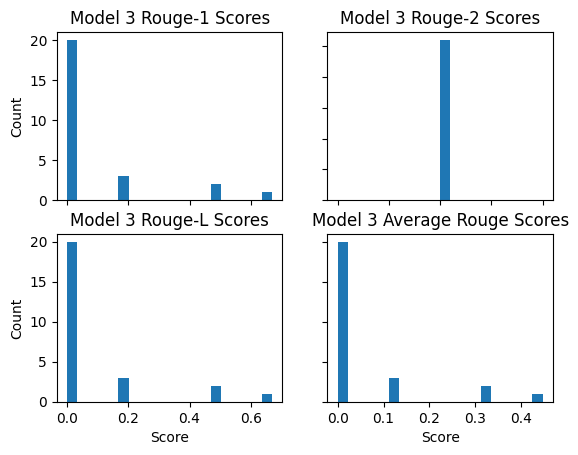

In [271]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(pred_df3["Score_1"], bins=20)
axs[0, 0].set_title('Model 3 Rouge-1 Scores')
axs[0, 1].hist(pred_df3["Score_2"], bins=20)
axs[0, 1].set_title('Model 3 Rouge-2 Scores')
axs[1, 0].hist(pred_df3["Score_L"], bins=20)
axs[1, 0].set_title('Model 3 Rouge-L Scores')
axs[1, 1].hist(pred_df3["Score_avg"], bins=20)
axs[1, 1].set_title('Model 3 Average Rouge Scores')

for ax in axs.flat:
    ax.set(xlabel='Score', ylabel='Count')

for ax in axs.flat:
    ax.label_outer()

print('The average Rouge-1 score for Model 3 is:', round(pred_df3.Score_1.mean(),2))
print('The average Rouge-2 score for Model 3 is:', round(pred_df3.Score_2.mean(),2))
print('The average Rouge-L score for Model 3 is:', round(pred_df3.Score_L.mean(),2))
print('The average of all Rouge scores for Model 3 is:', round(pred_df3.Score_avg.mean(),2))
print()

**OBSERVATIONS**

# Text Summarization with Transformers

As we just experienced developing our own sequence to sequence model can be very challenging. The 

For our final summarization attempt will be using the state of the are T5 and B

In [241]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [242]:
bart_df = SP_df[['Title', 'Text', 'Summary']]
bart_df.head()

,Title,Text,Summary
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors."
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award."
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano."
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park."
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant."


In [243]:
bart_df['reduced_text'] = textrank(corpus=bart_df.Text, ratio=.02)

In [244]:
import transformers
from transformers import pipeline

In [245]:
def bart(corpus):    
    nlp = transformers.pipeline("summarization")    
    lst_summaries = [nlp(txt,               
                         max_length=56, min_length=10, 
                         )[0]["summary_text"].replace(" .", ".")                    
                     for txt in corpus]    
    return lst_summaries

## Apply the function to corpus
bart_df.predicted = bart(corpus=bart_df["reduced_text"])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [246]:
predictions = []
for i in range(len(bart_df.predicted)):
  predictions.append(bart_df.predicted[i])
bart_df['preds'] = predictions

In [247]:
bart_df[['Summary', 'preds']].head()

,Summary,preds
0,"While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.","Kyle swings Ike by his feet, knocking Cartman down, knocking him down. Kyle Laughs: ""I can't just sit here, I have to help my stupid brother, or I'll come home without him and my dad will start y..."
1,"When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.","Mr. Garrison hears Kathie Lee singing in his head: ""If they could see me now, that little crowd of mine, and eating fancy chow..."" He wakes up startled. Cartman: ""Get out of my ass YOU STUPID RAINB"
2,"A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano.","Jimbo, Ned, and the boys are waiting for Cartman. The town is camping on a mountain, killing anyone who tries to climb to the top."
3,"When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park.",Stan forgot to mention that his dog is a gay homosexual.
4,"Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant.","According to Garrison Garrison, genetic engineering lets us correct God's horrible, horrible mistakes, like German people."


In [248]:
score_1 = []
score_2 = []
score_L = []

for i in range(len(bart_df)):   
    rouge_score = rouge.Rouge()    
    scores = rouge_score.get_scores(bart_df.Summary[i], bart_df.preds[i], avg=True)       
    score_1.append(round(scores['rouge-1']['f'], 2))
    score_2.append(round(scores['rouge-2']['f'], 2))
    score_L.append(round(scores['rouge-l']['f'], 2))    
    
bart_df["Score_1"] = score_1
bart_df['Score_2'] = score_2
bart_df['Score_L'] = score_L
bart_df['Score_avg'] = np.mean(bart_df[['Score_1', 'Score_2', 'Score_L']], axis=1)

The average Rouge-1 score for BART is: 0.16
The average Rouge-2 score for BART  is: 0.02
The average Rouge-L score for BART  is: 0.14
The average of all Rouge scores for BART  is: 0.11



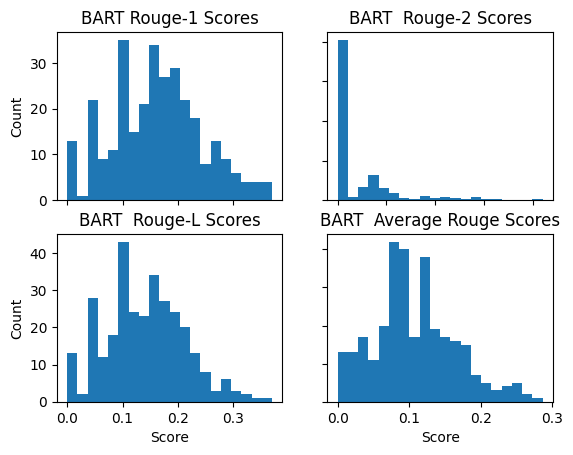

In [249]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(bart_df["Score_1"], bins=20)
axs[0, 0].set_title('BART Rouge-1 Scores')
axs[0, 1].hist(bart_df["Score_2"], bins=20)
axs[0, 1].set_title('BART  Rouge-2 Scores')
axs[1, 0].hist(bart_df["Score_L"], bins=20)
axs[1, 0].set_title('BART  Rouge-L Scores')
axs[1, 1].hist(bart_df["Score_avg"], bins=20)
axs[1, 1].set_title('BART  Average Rouge Scores')

for ax in axs.flat:
    ax.set(xlabel='Score', ylabel='Count')

for ax in axs.flat:
    ax.label_outer()

print('The average Rouge-1 score for BART is:', round(bart_df.Score_1.mean(),2))
print('The average Rouge-2 score for BART  is:', round(bart_df.Score_2.mean(),2))
print('The average Rouge-L score for BART  is:', round(bart_df.Score_L.mean(),2))
print('The average of all Rouge scores for BART  is:', round(bart_df.Score_avg.mean(),2))
print()

**OBSERVATIONS**

# Conclusions

In this project we explored different avenues of text summarization. We began with Gensim's TextRank algorythm, trained our own sequence-2-sequence model from skratch and then went on to use a state-of-the-art model like Facebook's BART. The goal of this project was to attempt to create a Sequence-to-Seqence model that can provide text summarizations of South Park episodes. Attempting to create such a model is always good practice when it comes to understanding certain concepts of NLP and neural networks. Having said that it is hard to compete with the pre-trained models available on [Hugging Face Transformers](https://huggingface.co/docs/transformers/index). 


# Recommendations

* Attempting to build your own Sequence-2-Sequence model from skratch for text summarization that is specific to South Park is very limiting. Incorporating additional dialogue from other texts and TV shows would help to produce a more useful model for our buisness case. 

* Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using these pretrained models can reduce your computing costs, carbon footprint, and save you the time and resources required to train a model from scratch. 

* Download a high performing pre-trained model, train it on South Park dialouge, and save it for future use. This will allow you to produce summaries quickly as new episodes are written.


# Limitations and Future Analysis

* Explore attention layers in neural network architecture. This could help improve model performance. 
* Compare and contrast different pre-trained models and their performance in summarizing South Park dialogue.
